Starting CA simulation on a 5x5 grid...
Iteration 10 Temperature Matrix:
[[100.         100.         100.         100.         100.        ]
 [  0.          41.58419968  50.87842304  41.58419968   0.        ]
 [  0.          16.96592896  22.4768512   16.96592896   0.        ]
 [  0.           5.89264896   8.05343232   5.89264896   0.        ]
 [  0.           0.           0.           0.           0.        ]]
Iteration 20 Temperature Matrix:
[[100.         100.         100.         100.         100.        ]
 [  0.          42.76975564  52.55498724  42.76975564   0.        ]
 [  0.          18.62642689  24.82524122  18.62642689   0.        ]
 [  0.           7.05548558   9.69786653   7.05548558   0.        ]
 [  0.           0.           0.           0.           0.        ]]
Iteration 30 Temperature Matrix:
[[100.         100.         100.         100.         100.        ]
 [  0.          42.85109066  52.67001233  42.85109066   0.        ]
 [  0.          18.74144091  24.98789561  1

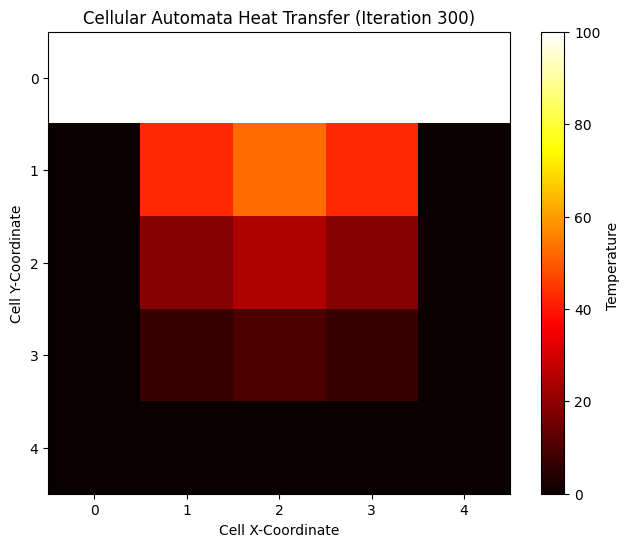

In [33]:
import numpy as np
import concurrent.futures
import matplotlib.pyplot as plt

# --- 1. Parameters ---
nx, ny = 5, 5  # Grid dimensions (10x10 for faster visualization)
iterations = 300  # Number of time steps (iterations)

# --- 2. Initial Temperature Distribution ---
T = np.zeros((nx, ny), dtype=float)  # Initial temperature field (all zeros)

# Boundary conditions (Dirichlet)
T[0, :] = 100  # Top boundary (Hot)
T[-1, :] = 0   # Bottom boundary (Cold)
T[1:, 0] = 0   # Left boundary
T[1:, -1] = 0 # Right boundary
# A small central hot spot for visualization

# --- 3. Cellular Automata Update Function (Parallel Unit) ---
def update_ca_row(i, T_current, ny):
    T_new_i = np.copy(T_current[i])
    for j in range(1, ny - 1):
        sum_neighbors = (T_current[i, j] +
                         T_current[i+1, j] +
                         T_current[i-1, j] +
                         T_current[i, j+1] +
                         T_current[i, j-1])
        T_new_i[j] = sum_neighbors / 5.0
    return i, T_new_i

# --- 4. Parallel Execution Manager ---
def update_temperature_parallel_ca(T_current, nx, ny):
    T_new = np.copy(T_current)
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = [executor.submit(update_ca_row, i, T_current, ny)
                  for i in range(1, nx - 1)]
        for future in concurrent.futures.as_completed(futures):
            i, updated_row = future.result()
            T_new[i] = updated_row
    return T_new

# --- 5. Main Loop and Visualization ---
plt.ion()  # Enable interactive mode

fig, ax = plt.subplots(figsize=(8, 6))
heatmap = ax.imshow(T, cmap='hot', interpolation='nearest', vmin=0, vmax=100)
cbar = fig.colorbar(heatmap, label="Temperature ")
ax.set_title("Cellular Automata Heat Transfer (Iteration 0)")
ax.set_xlabel("Cell X-Coordinate")
ax.set_ylabel("Cell Y-Coordinate")

print(f"Starting CA simulation on a {nx}x{ny} grid...")

# Loop through the iterations
for t in range(1, iterations + 1):
    T = update_temperature_parallel_ca(T, nx, ny)
    if t % 5 == 0 or t == iterations:
        heatmap.set_data(T)
        ax.set_title(f"Cellular Automata Heat Transfer (Iteration {t})")
        plt.draw()  # Small pause to update the plot

    # Print the matrix every 10 iterations
    if t % 10 == 0:
        print(f"Iteration {t} Temperature Matrix:")
        print(T)

print(f"Simulation finished after {iterations} iterations.")

# Keep the last heatmap displayed
plt.ioff()  # Turn off interactive mode
plt.show()  # Ensure the final plot is shown


<>:48: SyntaxWarning: invalid escape sequence '\c'
<>:48: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipython-input-2869284296.py:48: SyntaxWarning: invalid escape sequence '\c'
  cbar = fig.colorbar(heatmap, label="Temperature ($^\circ$C)")  # Colorbar with LaTeX label


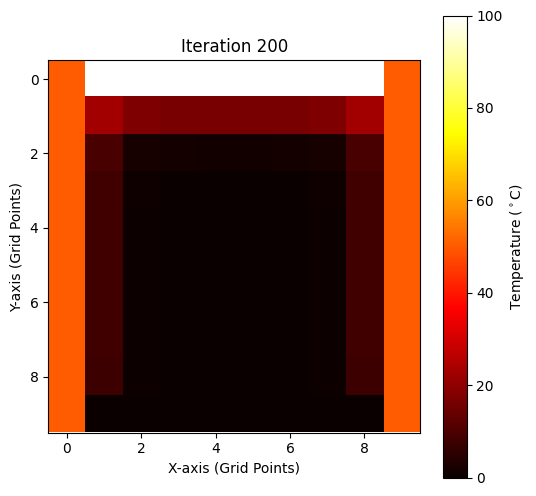

In [34]:
import numpy as np
import concurrent.futures
import matplotlib.pyplot as plt

# Parameters
nx, ny = 10, 10  # Grid dimensions (reduced for simplicity)
dx = dy = 1.0  # Grid spacing
alpha = 0.01  # Thermal diffusivity
dt = 0.1  # Time step
iterations = 200  # Number of iterations (time steps)

# Initial Temperature Distribution
T = np.zeros((nx, ny))  # Initial temperature field (all zeros)

# Boundary conditions
T[0, :] = 100  # Top boundary (hot surface)
T[-1, :] = 0   # Bottom boundary (cold surface)
T[:, 0] = 50    # Left boundary
T[:, -1] = 50   # Right boundary

# Function to update the temperature for a specific row
def update_row(i, T_current, alpha, dt, dx, ny):
    updated_row_i = np.copy(T_current[i])  # Copy of the current row to update
    for j in range(1, ny - 1):
        laplacian = (T_current[i + 1, j] + T_current[i - 1, j] +
                     T_current[i, j + 1] + T_current[i, j - 1] - 4 * T_current[i, j]) / dx ** 2
        updated_row_i[j] = T_current[i, j] + alpha * dt * laplacian
    return i, updated_row_i  # Return the row index and the updated row

# Function to update the temperature in parallel
def update_temperature_parallel(T_current, alpha, dt, dx, ny):
    T_new = np.copy(T_current)  # Create a new grid for updated values
    with concurrent.futures.ThreadPoolExecutor() as executor:
        # Submit row updates for all internal rows (1 to nx-2)
        futures = [executor.submit(update_row, i, T_current, alpha, dt, dx, ny)
                   for i in range(1, nx - 1)]  # No need to update the boundary rows
        # Collect results and update the new temperature matrix (T_new)
        for future in concurrent.futures.as_completed(futures):
            i, updated_row = future.result()
            T_new[i] = updated_row  # Update the new grid with the result
    return T_new

# --- Plotting and Main Loop (Remains largely the same) ---

# Create a figure for plotting
fig, ax = plt.subplots(figsize=(6, 6))
heatmap = ax.imshow(T, cmap='hot', interpolation='nearest', vmin=0, vmax=100)
cbar = fig.colorbar(heatmap, label="Temperature ($^\circ$C)")  # Colorbar with LaTeX label
plt.title("Temperature Distribution")
ax.set_xlabel("X-axis (Grid Points)")
ax.set_ylabel("Y-axis (Grid Points)")

# Loop through the iterations and update the heat map at each step
for t in range(1, iterations + 1):
    T = update_temperature_parallel(T, alpha, dt, dx, ny)  # Update grid with heat diffusion
    if t % 10 == 0 or t == iterations:
        heatmap.set_data(T)  # Update the heatmap data
        ax.set_title(f"Iteration {t}")  # Update title with current iteration
        plt.draw()  # Redraw the plot

# Show the final heatmap
plt.show()
